In [1]:
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool
from kaggle_hm.chart_model import filter_data
from copy import deepcopy
import numpy as np
import os
import seaborn as sns
import pandas as pd
from kaggle_hm.config import data_root, train_dates, test_dates
from kaggle_hm.evaluation import compute_precision
import kaggle_hm.als_model
from kaggle_hm.chart_model import age_chart

In [2]:
c = pd.read_parquet(data_root / 'clean' / 'customers.parquet').set_index('customer_id')
c['age'] = c['age'].fillna(c['age'].mean())
c['age_group'] = pd.cut(c['age'], bins=[15, 21, 25, 30, 40, 50, 60, 100])

In [3]:
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')
df = df.merge(c, left_on='customer_id', right_index=True)

cols = [f'rel_{i + 1}' for i in range(12)]

train = filter_data(df, from_date='2020-09-01', to_date=train_dates['end'])
test = filter_data(df, from_date=test_dates['start'], to_date=test_dates['end'])

results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()

old_customers = set(filter_data(df, to_date=train_dates['end'])['customer_id'].unique())

In [4]:
train_nodup = train.drop_duplicates(subset=['customer_id', 'article_id'])

In [5]:
candidates = pd.read_parquet(data_root / 'clean' / 'candidates.parquet')
candidates = candidates.merge(train_nodup[['customer_id', 'article_id', 't_dat']], on=['customer_id', 'article_id'], how='left')
candidates['bought'] = candidates['t_dat'].notna().astype('int')

In [6]:
from sklearn.model_selection import train_test_split

customers = candidates['customer_id'].unique()

train_customers, test_customers = train_test_split(customers, test_size=0.2, random_state=42)

In [7]:
features = ['score', 'bought']

train_df = candidates[candidates['customer_id'].isin(train_customers)].copy()
test_df = candidates[candidates['customer_id'].isin(test_customers)].copy()

X_train = train_df[features]
y_train = train_df['is_relevant']
queries_train = train_df['customer_id']

X_test = test_df[features]
y_test = test_df['is_relevant']
queries_test = test_df['customer_id']

In [8]:
train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train,
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test
)

default_parameters = {
    'iterations': 2000,
    'custom_metric': ['MAP:top=10', 'NDCG'],
    'verbose': True,
    'metric_period': 200,
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': 0,
}

parameters = {}

In [9]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)

    return model

In [10]:
model = fit_model('PairLogit')

Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6830921	test: 0.6836909	best: 0.6836909 (0)	total: 249ms	remaining: 8m 17s
200:	learn: 0.5334487	test: 0.5430030	best: 0.5430030 (200)	total: 5.11s	remaining: 45.7s
400:	learn: 0.5329186	test: 0.5428254	best: 0.5428254 (400)	total: 9.94s	remaining: 39.6s
600:	learn: 0.5327793	test: 0.5428812	best: 0.5428254 (400)	total: 14.8s	remaining: 34.4s
800:	learn: 0.5327038	test: 0.5428741	best: 0.5428254 (400)	total: 19.6s	remaining: 29.3s
1000:	learn: 0.5326509	test: 0.5429069	best: 0.5428254 (400)	total: 24.3s	remaining: 24.3s
1200:	learn: 0.5326087	test: 0.5429279	best: 0.5428254 (400)	total: 29.1s	remaining: 19.4s
1400:	learn: 0.5325808	test: 0.5429523	best: 0.5428254 (400)	total: 33.9s	remaining: 14.5s
1600:	learn: 0.5325524	test: 0.5429743	best: 0.5428254 (400)	total: 38.6s	remaining: 9.63s
1800:	learn: 0.5325307	test: 0.5429773	best: 0.5428254 (400)	total: 43.4s	remaining: 4.79s
1999:	learn: 0.5325154	test: 0.5429927	best: 0.5428254 (400)	total: 48.2s	remaining: 0us
bestTest 

In [12]:
predictions = model.predict(X_test)
test_df['prediction'] = predictions
test_df['rank'] = test_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')

relevant_items = test_df.query('rank <= 12').sort_values(['customer_id', 'rank'], ascending=True)
rec_df = (
    relevant_items.groupby('customer_id', observed=True).agg(candidates=('article_id', list))
)

In [13]:
from catboost.utils import eval_metric

eval_metric(y_test.values, predictions, 'MAP:top=12', group_id=queries_test.values)

[0.043821094714607635]

In [14]:
model.get_best_score()

{'learn': {'MAP:top=10': 0.042970451517291036,
  'PairLogit': 0.5325154141830996},
 'validation': {'NDCG:type=Base': 0.8238791243633097,
  'MAP:top=10': 0.04304072240087903,
  'PairLogit': 0.5428254384795957}}

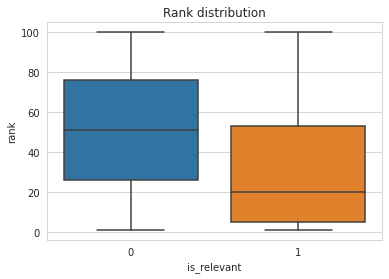

In [15]:
sns.boxplot(data=test_df, x='is_relevant', y='rank')
plt.title('Rank distribution');

In [16]:
comb = results.merge(rec_df, on='customer_id')
comb['prediction'] = comb['candidates']
comb = compute_precision(comb)
comb['precision'].mean()

0.03163507085389067

count    1000.000000
mean        0.031665
std         0.004053
min         0.022065
25%         0.028740
50%         0.031442
75%         0.034367
max         0.047623
dtype: float64


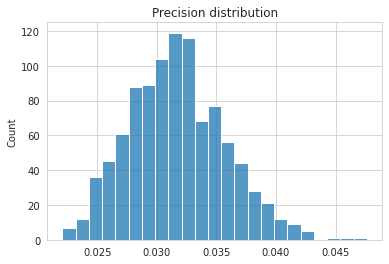

In [17]:
N = 1000
precisions = np.zeros(N)
for i in range(N):
    precisions[i] = comb.sample(n=1000)['precision'].mean()

print(pd.Series(precisions).describe())
sns.histplot(precisions)
plt.title('Precision distribution');

# submission

In [18]:
submission = pd.read_csv('/data/sstamenov/kaggle-data/sample_submission.csv').drop(columns=['prediction'])
submission = submission.merge(c, left_on='customer_id', right_index=True)
delta = (pd.to_datetime('2020-09-22') - df['t_dat']).dt.days
df['delta_weeks'] = 1 / (1 + np.power(delta // 7, 1))

In [19]:
submission.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"(40, 50]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"(21, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(21, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"(50, 60]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"(50, 60]"


In [20]:
full_ds = filter_data(df, to_date='2020-09-22')
train = filter_data(df, '2020-09-15', '2020-09-22')

pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='time', factors=256, iterations=50, regularization=0.01)
pipeline.fit(train)
rec_df = pipeline.predict(full_ds, N=100)

#items 18684
#customers 75481


  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
train_nodup = train.drop_duplicates(subset=['customer_id', 'article_id'])

rec_df = rec_df.merge(train_nodup[['customer_id', 'article_id', 't_dat']], on=['customer_id', 'article_id'], how='left')
rec_df['bought'] = rec_df['t_dat'].notna().astype('int')

In [23]:
rec_df.head()

,item_id,score,customer_id,article_id,t_dat,bought
0,0,0.376923,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,2020-09-15,1
1,339,0.266049,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0805000001,NaT,0
2,992,0.198383,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0805000008,NaT,0
3,187,0.191469,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0805000007,NaT,0
4,2962,0.169525,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321008,NaT,0


In [24]:
X_pred = rec_df[['score', 'bought']]

In [25]:
predictions = model.predict(X_pred)
rec_df['prediction'] = predictions
rec_df['rank'] = rec_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')

relevant_items = rec_df.query('rank <= 12').sort_values(['customer_id', 'rank'], ascending=True)
pred_df = (
    relevant_items.groupby('customer_id', observed=True).agg(candidates=('article_id', list))
)

In [26]:
pred_df.head()

,candidates
customer_id,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,"[0568601043, 0779781015, 0568601006, 056859700..."
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,"[0739590027, 0590928001, 0882759003, 035148403..."
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,"[0794321007, 0805000001, 0805000008, 080500000..."
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,"[0896152002, 0730683050, 0791587015, 089615200..."
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,"[0448509014, 0719530003, 0448509018, 044850900..."


In [27]:
pred_df.shape[0]

1105000

In [28]:
top12_age_pred = age_chart(train)
submission = submission.merge(pred_df, on='customer_id', how='left')
submission = submission.merge(top12_age_pred, on='age_group', how='left').drop(columns=['age_group'])
submission['prediction'] = submission['candidates'].combine_first(submission['naive_pred'])

In [31]:
submission['candidates'].notna().sum()

1105000

In [29]:
submission.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[0568601043, 0779781015, 0568601006, 056859700...","[0751471001, 0923758001, 0924243001, 092424300...","[0568601043, 0779781015, 0568601006, 056859700..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[0739590027, 0590928001, 0882759003, 035148403...","[0924243001, 0918522001, 0924243002, 091552900...","[0739590027, 0590928001, 0882759003, 035148403..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[0794321007, 0805000001, 0805000008, 080500000...","[0924243001, 0918522001, 0924243002, 091552900...","[0794321007, 0805000001, 0805000008, 080500000..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,NaN,"[0924243001, 0928206001, 0930380001, 092424300...","[0924243001, 0928206001, 0930380001, 092424300..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[0896152002, 0730683050, 0791587015, 089615200...","[0924243001, 0928206001, 0930380001, 092424300...","[0896152002, 0730683050, 0791587015, 089615200..."


In [30]:
submission.shape[0]

1371980

In [32]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [33]:
submission[['customer_id', 'prediction']].to_csv('/data/sstamenov/kaggle-data/output/implicit_time_ranked_submission.csv', index=False)